In [133]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import sweetviz as sv
import plotly.graph_objs as pg
import plotly.figure_factory as ffc
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [118]:
 #-----------SPRACOVANIE DAT--------------#

df = pd.read_csv("weather_data.csv")
test_data = pd.read_csv("weather_data.csv")

# najskor pridam do irradiance vsade 0 aby sa neodstranilo prilis vela zaznamov

df["Irradiance"] = df["Irradiance"].fillna(0.0)

# zistili sme ze v nasom datasete sa nachádza 277 null hodnôt okrem (stlpca Irradiance)
# pre dataset nasich rozmerov je to pomerne mali pocet zaznamov a preto sme sa 
# ich rozhodli odstranit
print(f"There are: {df.isnull().sum().sum()} null values in dataset")

print(df.isnull().sum())

# odstranenie prazdnych zaznamov
df = df.dropna()
df = df.drop_duplicates(keep='first')
df = df.fillna(0)

df = df.drop('Irradiance', axis=1)


There are: 277 null values in dataset
Temperature             44
Humidity                35
Wind Speed              38
Precipitation (%)       33
Cloud Cover              0
Atmospheric Pressure    44
UV Index                36
Season                   0
Visibility (km)         47
Location                 0
Weather Type             0
Irradiance               0
dtype: int64


In [119]:
# zistenie kolko roznych druhov Cloud Cover sa nachadza v DB a ich zakodovnie
# Cloud Cover sme si vybrali druh kodovanie: Label Encoding 

unique_values_cloud = df['Cloud Cover'].unique()
print(f"Unique words: {unique_values_cloud}")
print(f"Number of unique words cloud: {len(unique_values_cloud)}")

df['Cloud Cover Encoded'] = pd.factorize(df['Cloud Cover'])[0]

#unique_values_weather = df['Weather Type'].unique()
#print(f"Unique words: {unique_values_weather}")
#print(f"Number of unique words weather: {len(unique_values_weather)}")

#df['Weather Type Encoded'] = pd.factorize(df['Weather Type'])[0]

unique_values_location = df['Location'].unique()
print(f"Unique words: {unique_values_location}")
print(f"Number of unique words location: {len(unique_values_location)}")

# na stlpec season sme vybrali druh zakódovania One-Hot Encoding

df_one_hot = pd.get_dummies(df['Season'], prefix='Season')
df = pd.concat([df, df_one_hot], axis = 1)


Unique words: ['partly cloudy' 'clear' 'overcast' 'cloudy']
Number of unique words cloud: 4
Unique words: ['inland' 'mountain' 'coastal' 'island']
Number of unique words location: 4


In [120]:
# Vyhľadanie duplicitných záznamov

duplicate = df[df.duplicated()]
df = df.drop_duplicates()
print("Number of records in dataset: "+str(len(df)))
print("There are: " + str(len(duplicate)) + " duplicates.")



Number of records in dataset: 12925
There are: 0 duplicates.


In [121]:
# Teraz potrebujeme odstrániť outliery v stĺpcos v ktorých boli originálne numerické hodnoty

numeric_columns = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)'
                   , 'Atmospheric Pressure', 'Visibility (km)'
                  ]
# Identifikovanie outlierov na zaklade metody IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# nakreslenie boxplotov pre outliery v jednotlivych stlpcoch

#for column in numeric_columns:
#    plt.figure(figsize=(10, 5))
#    sns.boxplot(x=train_data[column])
#    plt.title(f"Boxplot of {column}")
#    plt.show()

# zistili sme ze v nasom datasete sa nenachadzaju outliery
for column in numeric_columns:
    outliers = detect_outliers(df, column)
    # Remove the outliers
    df = df[(df[column] >= df[column].quantile(0.25) - 1.5 * (df[column].quantile(0.75) - df[column].quantile(0.25))) & 
            (df[column] <= df[column].quantile(0.75) + 1.5 * (df[column].quantile(0.75) - df[column].quantile(0.25)))]

# po vypisani stats sme aj tak nasli viacere nejasnosti ako vlhkosť väčšia ako 100%, podozrivo vysoká teplota 66C (vyhodnotili sme ako vporiadku)
# množstvo zrážok -60

# tymto hodnotam sme dali fixne max a min 
df['Humidity'] = df['Humidity'].clip(lower=0, upper=100)
df['Precipitation (%)'] = df['Precipitation (%)'].clip(lower=0, upper=100)

# kontrola datasetu, hodnoty vyzeraju v norme
print(df.describe())



        Temperature      Humidity    Wind Speed  Precipitation (%)  \
count  11406.000000  11406.000000  11406.000000       11406.000000   
mean      19.087933     69.390496      9.213309          51.887983   
std       15.928408     19.200396      5.611486          31.891207   
min      -24.000000     20.000000      0.000000           0.000000   
25%        7.000000     59.000000      5.000000          18.000000   
50%       22.000000     70.000000      8.500000          56.000000   
75%       30.000000     84.000000     13.500000          81.000000   
max       71.000000    100.000000     26.000000         100.000000   

       Atmospheric Pressure  Visibility (km)  Cloud Cover Encoded  \
count          11406.000000     11406.000000         11406.000000   
mean            1006.259216         5.109459             1.129055   
std               12.932154         2.609789             0.905632   
min              962.880000        -3.010798             0.000000   
25%              995.812

In [122]:
df = df.drop(columns=[ 'Season', 'Location'])

print(df.describe())


# funkcia zabezpecujuca normalizaciu pouzitim MinMaxScaler kniznice
#def normalization(df):
#    for col in df.columns:
#        df[col] = MinMaxScaler().fit_transform(np.array(df[col]).reshape(-1, 1))

# normalizacia trenovacich dat

#normalization(df)

# normalizacia testovacich dat
# normalization(test_data)

        Temperature      Humidity    Wind Speed  Precipitation (%)  \
count  11406.000000  11406.000000  11406.000000       11406.000000   
mean      19.087933     69.390496      9.213309          51.887983   
std       15.928408     19.200396      5.611486          31.891207   
min      -24.000000     20.000000      0.000000           0.000000   
25%        7.000000     59.000000      5.000000          18.000000   
50%       22.000000     70.000000      8.500000          56.000000   
75%       30.000000     84.000000     13.500000          81.000000   
max       71.000000    100.000000     26.000000         100.000000   

       Atmospheric Pressure  Visibility (km)  Cloud Cover Encoded  \
count          11406.000000     11406.000000         11406.000000   
mean            1006.259216         5.109459             1.129055   
std               12.932154         2.609789             0.905632   
min              962.880000        -3.010798             0.000000   
25%              995.812

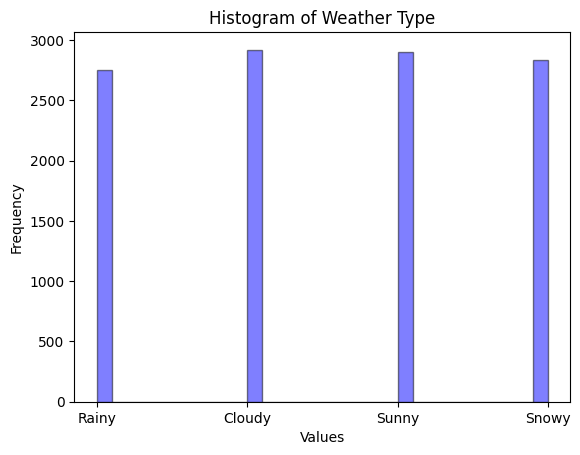

((3421, 13), (3421,), (3422, 13), (3422,), (4563, 13), (4563,))

In [130]:
X = df.drop(columns='Weather Type')
Y = df['Weather Type']

# Najprv rozdelíme dáta na trénovaciu a testovaciu množinu (60% tréning, 40% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# Potom rozdelíme trénovaciu množinu na tréningovú a validačnú množinu (50% tréning, 50% validačná)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.50, random_state=42)

# Výsledné množiny:
# X_train, y_train - Trénovacie dáta
# X_val, y_val - Validačné dáta
# X_test, y_test - Testovacie dáta

plt.hist(df['Weather Type'], bins=30, color='blue', edgecolor='black', alpha=0.5)  # Nahradiť target_column názvom stĺpca

plt.title('Histogram of Weather Type')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.show()

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

In [135]:
# Inicializujeme scaler
scaler = StandardScaler()

# Fit-transformácia len na tréningových dátach
X_train_scaled = scaler.fit_transform(X_train)

# Na validačnej a testovacej množine len transformácia
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Kontrola tvarov množín po škálovaní
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Vykreslenie histogramu pre škálované dáta
plt.hist(X_train_scaled.flatten(), bins=30, color='blue', edgecolor='black', alpha=0.5)
plt.title('Histogram of Scaled Features (X_train)')
plt.xlabel('Scaled Values')
plt.ylabel('Frequency')
plt.show()

ValueError: could not convert string to float: 'overcast'

In [125]:
# korelacna matica
corr_matrix = px.imshow(df.corr())
corr_matrix.show()

C:\Users\mraff\AppData\Local\Temp\ipykernel_39980\2365527316.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

